# Scan MERRA-2 atmospheric properties during one month
----------------------------------------------------------------------------------

- author: Sylvie Dagoret-Campagne
- creation January 12 2017
- update January 16 2016

Link:

http://disc.sci.gsfc.nasa.gov/datareleases/merra_2_data_release

### purpose:

Scan One month of MERRA-2 predictions of the dataset inst1_2d_asm_Nx_M2I1NXASM. 
Extract the relevant atmospheric variables.
Build the correcponding time series and dataset in pandas.
Plot the variables. Save the pandas dataset into a file.
Convert the pandas dataset into an astropy fits table and save into a fits file as well.



## 1) python libraries
---------------------------

In [1]:
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib as mpl
matplotlib.rc_file("templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

/Users/dagoret-campagnesylvie/.local/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import datetime

In [3]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [4]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [5]:
import os
import re
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

In [6]:
from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.table import Table

In [7]:
import h5py

In [8]:
import libGMAOMERRA2Data as merra2  # My own library

In [9]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

## 2)  Configuration
-------------------------

In [10]:
# SELECT MONTH IN 2016
MONTH_NAME='11' # select october

In [11]:
# SELECT OBSERVATORY
OBS_NAME='ohp'

In [12]:
# where are the HDF files
HDFEOS_ZOO_DIR="/Volumes/LaCie2/DATA/MERRA-2/inst1_2d_asm_Nx_M2I1NXASM"

In [13]:
path=HDFEOS_ZOO_DIR

### Here I describe the content of the input files

In [14]:
DATA_TAG=['PS','T10M','T2M','TO3','TOX','TQI','TQL','TS','U10M','U2M','U50M','V10M','V2M','V50M' ]

In [15]:
DATA_TITLE=['Surface Pressure',
            '10 meter air temperature',
            '2 meter air temperature',
            'total column ozone',
            'total column odd oxygen',
            'total precipitable ice water',
            'total precipitable liquid water',
            'Surface Temperature skin',
            '10 meter eastward wind',
            '2 meter eastward wind',
            '50 meter eastward wind',
            '10 meter northward wind',
            '2 meter northward wind',
            '50 meter northward wind'
           ]

In [16]:
NB_DATAFIELDS=len(DATA_TAG)

### List of output files

In [17]:
# The selected data field
DATA_NAME =  'inst1_2d_asm_Nx_M2I1NXASM'   # 

In [18]:
pandas_filename='MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'.csv'

In [19]:
fits_filename='MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME +'.fits'

In [20]:
# 14 output files for figures
figfile_ps='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_ps'+'.jpg'
figfile_t10='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_t10'+'.jpg'
figfile_t2='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_t2'+'.jpg'
figfile_to3='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_to3'+'.jpg'
figfile_tox='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_tox'+'.jpg'
figfile_tqi='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_tqi'+'.jpg'
figfile_tql='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_tql'+'.jpg'
figfile_ts='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_ts'+'.jpg'
figfile_u10m='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_u10m'+'.jpg'
figfile_u2m='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_u2m'+'.jpg'
figfile_u50m='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_u50m'+'.jpg'
figfile_v10m='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_v10m'+'.jpg'
figfile_v2m='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_v2m'+'.jpg'
figfile_v50m='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_v50m'+'.jpg'

### Select where in the world

In [21]:
# Select observatory
loc=merra2.observatory_location(OBS_NAME)

In [22]:
loc

(5.71222222222, 43.9316666667, 650.0)

### 2.2) Getting the list of the files
------------------------------

In [23]:
nc4_files = [f for f in os.listdir(path) if f.endswith('.nc4')]  

In [24]:
nc4_files[:5]

['MERRA2_400.inst1_2d_asm_Nx.20160101.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20160102.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20160103.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20160104.nc4',
 'MERRA2_400.inst1_2d_asm_Nx.20160105.nc4']

### 2.3) Select files of a given month

In [25]:
keysel_filename='^MERRA2_400.inst1_2d_asm_Nx.2016{}.*'.format(MONTH_NAME)

In [26]:
print 'Selection key' ,keysel_filename

Selection key ^MERRA2_400.inst1_2d_asm_Nx.201611.*


In [27]:
nc4_files2 = []
for file in nc4_files:
    if re.findall(keysel_filename,file):
        nc4_files2.append(file)

nc4_files2=np.array(nc4_files2)

In [28]:
nc4_files2

array(['MERRA2_400.inst1_2d_asm_Nx.20161101.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161102.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161103.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161104.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161105.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161106.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161107.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161108.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161109.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161110.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161111.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161112.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161113.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161114.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161115.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161116.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161117.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161118.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161119.nc4',
       'MERRA2_400.inst1_2d_asm_Nx.20161120.nc4',


### 2.4) Sort files by increasing time

In [29]:
nc4_files=np.sort(nc4_files2)

### 2.5) Build the full filename before reading

In [30]:
NBFILES=len(nc4_files)
full_nc4files=[]

for file in nc4_files:
    fname = os.path.join(path, file)
    full_nc4files.append(fname)  

## 3)  Extract data and write them into pandas dataset and time series
--------------------------------------------------------------------------------------

In [31]:
ts0=[]  # intermediate data series
ts1=[]
ts2=[]
ts3=[]  # intermediate data series
ts4=[]
ts5=[]
ts6=[]  # intermediate data series
ts7=[]
ts8=[]
ts9=[]  # intermediate data series
ts10=[]
ts11=[]
ts12=[]
ts13=[]

df_inst1_2d_asm_Nx=[] # final pandas dataset for all atmospheric quantities

for file in full_nc4files: # loop on data file of each day of the month
    
    #Retrieve 1D parameters longitude, latitude, time
    (m_lat,m_un_lat,m_nm_lat) = merra2.Get1DData(file,'lat') # latitude (array, unit, name)
    m_latitude = m_lat[:]
    (m_lon,m_un_lon,m_nm_lon) = merra2.Get1DData(file,'lon') # longitude(array, unit, name)
    m_longitude = m_lon[:]
    (m_tim,m_un_tim,m_nm_tim)= merra2.Get1DData(file,'time') # time (array, unit, name)
    m_time=m_tim[:]
       
    NbDataPerFile=m_time.shape[0] # number of data sample per file
    #start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)[ ]00:00:00$",m_un_tim) # extract start time
    start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)",m_un_tim) # extract start time
    
    #print 'start_time = ', start_time
    time_rng = pd.date_range(start_time[0], periods=NbDataPerFile, freq='H') # one data per hour
    
    print 'start_time = ', start_time
    
    m_X,m_Y=np.meshgrid(m_longitude,m_latitude) # build meash-grid in longitude and latitude
    (sel_long, sel_lat)=merra2.GetBinIndex(m_X,m_Y,loc[0],loc[1]) # get bin in longitude and latitude for the site  
    
 
    # loop
    for index in range(NB_DATAFIELDS):
        (m_data,m_unit,m_longname)=merra2.GetGeoRefData(file,DATA_TAG[index]) # 3D array : time x longitude x latitude  
        dt=m_data[:,sel_lat,sel_long]
        if index==0:
            ts0 = pd.Series(dt, index=time_rng)
        elif index==1:
            ts1 = pd.Series(dt, index=time_rng)
        elif index==2:
            ts2 = pd.Series(dt, index=time_rng)
        elif index==3:
            ts3 = pd.Series(dt, index=time_rng)

        elif index==4:
            ts4 = pd.Series(dt, index=time_rng)
        elif index==5:
            ts5 = pd.Series(dt, index=time_rng)
        elif index==6:
            ts6 = pd.Series(dt, index=time_rng)
            
        elif index==7:
            ts7 = pd.Series(dt, index=time_rng)
        elif index==8:
            ts8 = pd.Series(dt, index=time_rng)
        elif index==9:
            ts9 = pd.Series(dt, index=time_rng)            
            
        elif index==10:
            ts10 = pd.Series(dt, index=time_rng)
        elif index==11:
            ts11 = pd.Series(dt, index=time_rng)
        elif index==12:
            ts12 = pd.Series(dt, index=time_rng) 
            
        elif index==13:
            ts13 = pd.Series(dt, index=time_rng) 
            
            
        #clf_timeseries.append(ts)
        # Create the dataframe
    df = pd.DataFrame({DATA_TAG[0]: ts0, 
                       DATA_TAG[1]: ts1,
                       DATA_TAG[2]: ts2,
                       DATA_TAG[3]: ts3,
                       
                       DATA_TAG[4]: ts4,
                       DATA_TAG[5]: ts5,
                       DATA_TAG[6]: ts6,                       

                       DATA_TAG[7]: ts7,
                       DATA_TAG[8]: ts8,
                       DATA_TAG[9]: ts9,
                       
                       DATA_TAG[10]: ts10,
                       DATA_TAG[11]: ts11,
                       DATA_TAG[12]: ts12,
                       DATA_TAG[13]: ts13 }, index=time_rng)
    df_inst1_2d_asm_Nx.append(df)  
    

start_time =  ['2016-11-01 00:00:00']
start_time =  ['2016-11-02 00:00:00']
start_time =  ['2016-11-03 00:00:00']
start_time =  ['2016-11-04 00:00:00']
start_time =  ['2016-11-05 00:00:00']
start_time =  ['2016-11-06 00:00:00']
start_time =  ['2016-11-07 00:00:00']
start_time =  ['2016-11-08 00:00:00']
start_time =  ['2016-11-09 00:00:00']
start_time =  ['2016-11-10 00:00:00']
start_time =  ['2016-11-11 00:00:00']
start_time =  ['2016-11-12 00:00:00']
start_time =  ['2016-11-13 00:00:00']
start_time =  ['2016-11-14 00:00:00']
start_time =  ['2016-11-15 00:00:00']
start_time =  ['2016-11-16 00:00:00']
start_time =  ['2016-11-17 00:00:00']
start_time =  ['2016-11-18 00:00:00']
start_time =  ['2016-11-19 00:00:00']
start_time =  ['2016-11-20 00:00:00']
start_time =  ['2016-11-21 00:00:00']
start_time =  ['2016-11-22 00:00:00']
start_time =  ['2016-11-23 00:00:00']
start_time =  ['2016-11-24 00:00:00']
start_time =  ['2016-11-25 00:00:00']
start_time =  ['2016-11-26 00:00:00']
start_time =

### Concatenation

In [32]:
df_inst1_2d_asm_Nx=pd.concat(df_inst1_2d_asm_Nx)

In [33]:
df_inst1_2d_asm_Nx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2016-11-01 00:00:00 to 2016-11-30 23:00:00
Data columns (total 14 columns):
PS      720 non-null float32
T10M    720 non-null float32
T2M     720 non-null float32
TO3     720 non-null float32
TOX     720 non-null float32
TQI     720 non-null float32
TQL     720 non-null float32
TS      720 non-null float32
U10M    720 non-null float32
U2M     720 non-null float32
U50M    720 non-null float32
V10M    720 non-null float32
V2M     720 non-null float32
V50M    720 non-null float32
dtypes: float32(14)
memory usage: 45.0 KB


## 4) Plot the time dependence of time series and dataset

####  Fill information on years and months from the filenames

In [34]:
def PlotTimeSeries(index,figfile):
    plt.figure(figsize=(20,5))
    df_inst1_2d_asm_Nx[DATA_TAG[index]].plot(lw=3,color='red')
    plt.xlabel('time')
    plt.ylabel(DATA_TAG[index])
    title= "Hourly {} at {} in 2016/{}".format(DATA_TITLE[index],OBS_NAME,MONTH_NAME)
    plt.title(title,fontsize=15)
    plt.suptitle('NASA GMAO GES (MERRA-2)', y=1.02, fontsize=13)
    plt.grid(True)
    plt.savefig(figfile)

### 4.1) Pressure

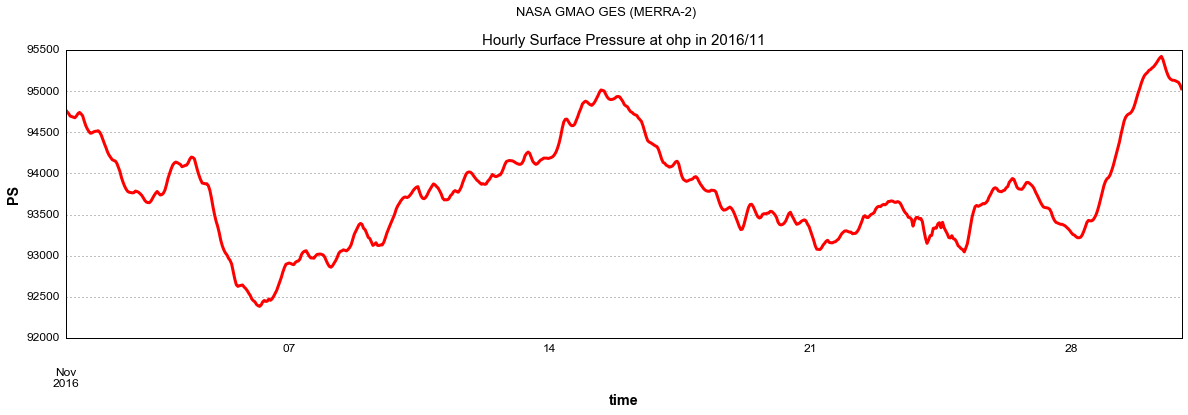

In [35]:
PlotTimeSeries(0,figfile_ps)

In [36]:
figfile_ps='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_ps'+'.jpg'
figfile_t10='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_t10'+'.jpg'
figfile_t2='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_t2'+'.jpg'
figfile_to3='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_to3'+'.jpg'
figfile_tox='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_tox'+'.jpg'
figfile_tqi='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_tqi'+'.jpg'
figfile_tql='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_tql'+'.jpg'
figfile_ts='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_ts'+'.jpg'
figfile_u10m='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_u10m'+'.jpg'
figfile_u2m='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_u2m'+'.jpg'
figfile_u50m='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_u50m'+'.jpg'
figfile_v10m='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_v10m'+'.jpg'
figfile_v2m='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_v2m'+'.jpg'
figfile_v50m='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_v50m'+'.jpg'

###  4.2)  T10
----------------

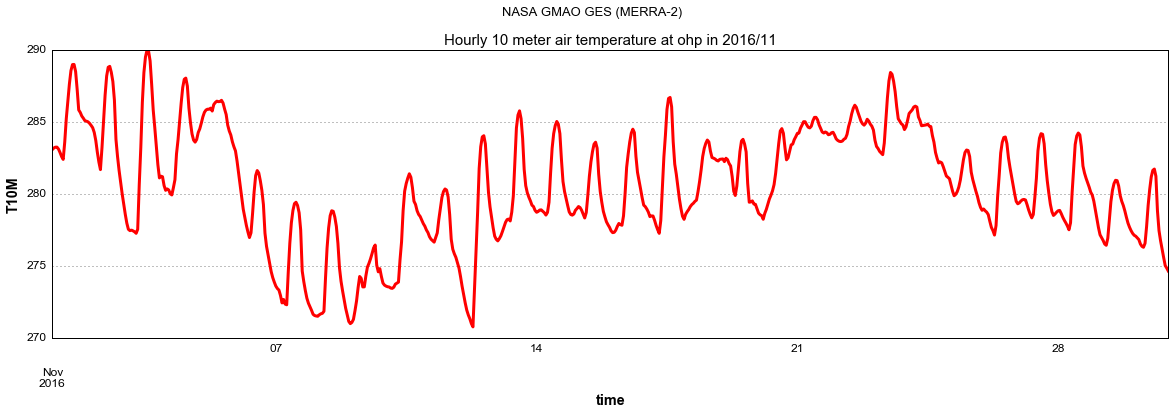

In [37]:
PlotTimeSeries(1,figfile_t10)

### 4.3) t2

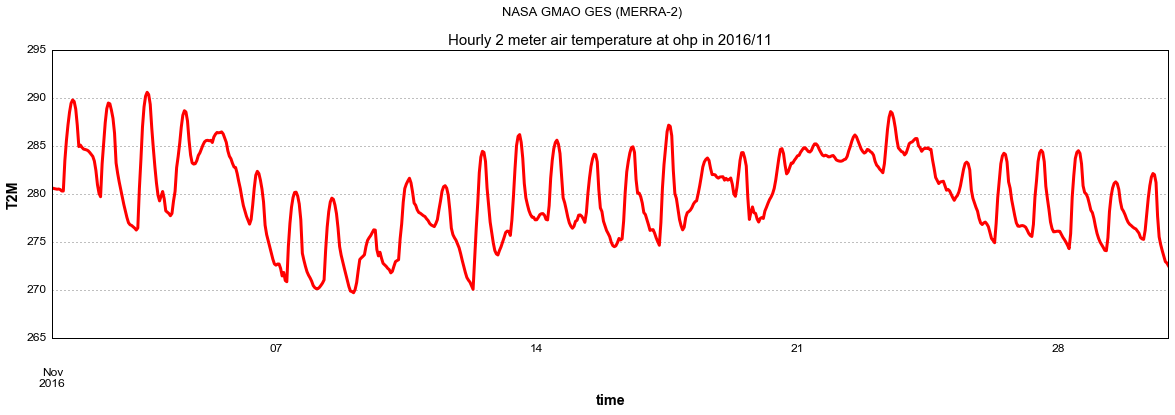

In [38]:
PlotTimeSeries(2,figfile_t2)

### 4.4) to3

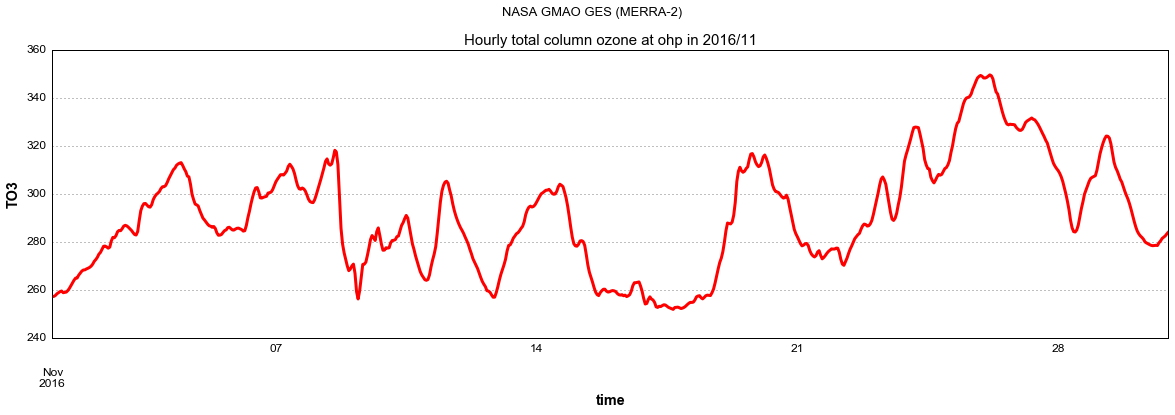

In [39]:
PlotTimeSeries(3,figfile_to3)

### 4.5) tox

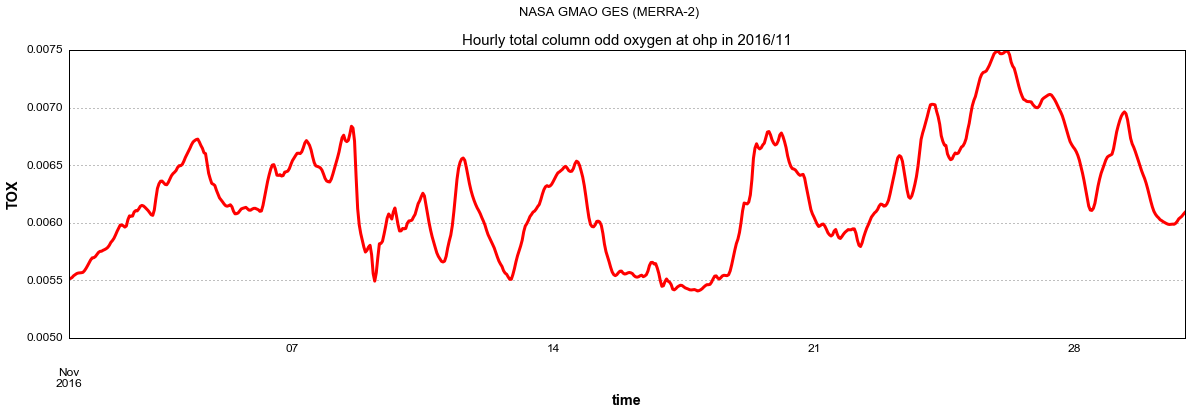

In [40]:
PlotTimeSeries(4,figfile_tox)

### 4.6 TQI

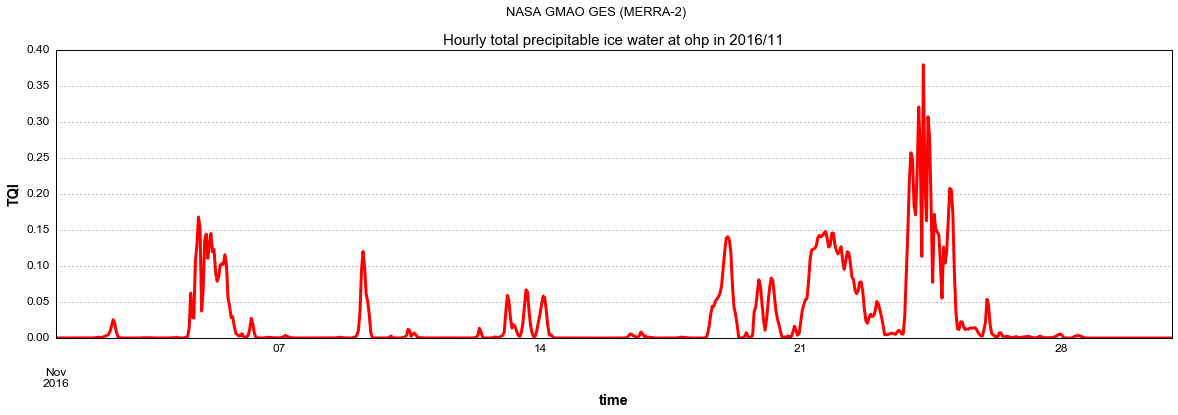

In [41]:
PlotTimeSeries(5,figfile_tqi)

### 4.7) TQL

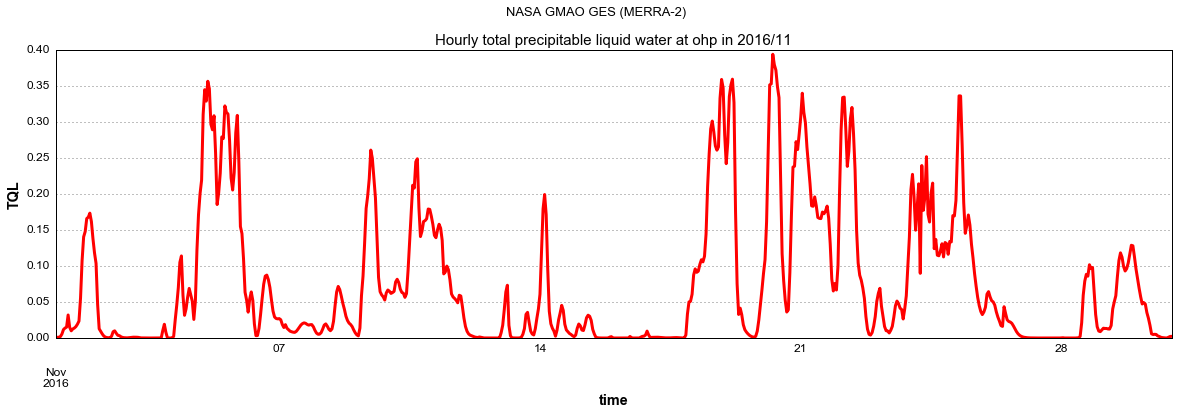

In [42]:
PlotTimeSeries(6,figfile_tql)

### 4.8) TS

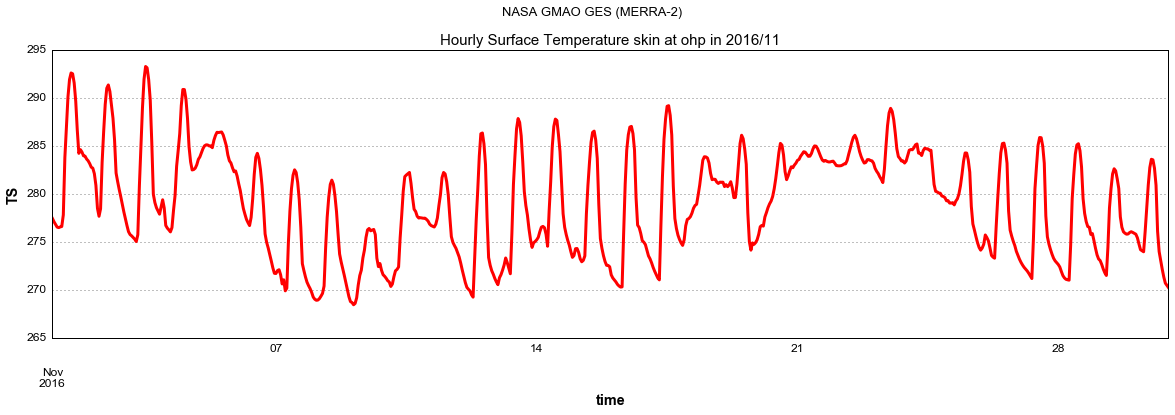

In [43]:
PlotTimeSeries(7,figfile_ts)

### 4.9) um10

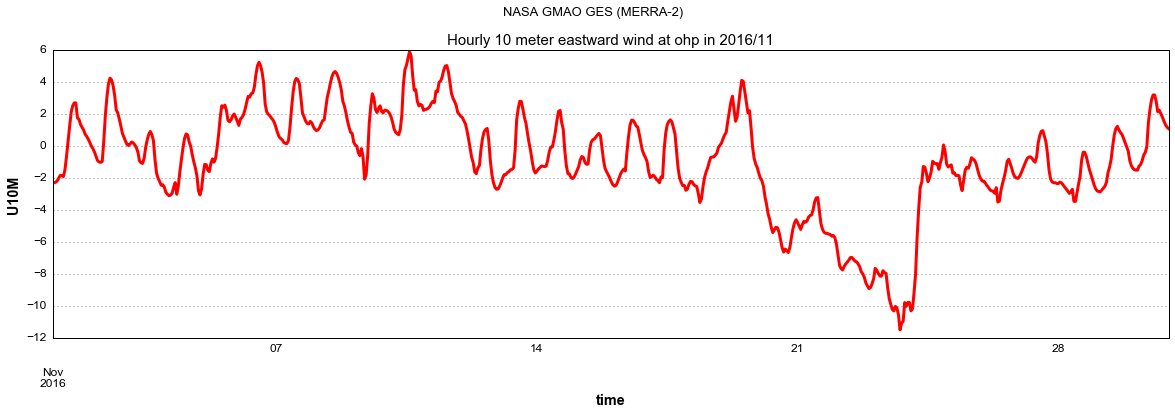

In [44]:
PlotTimeSeries(8,figfile_u10m)

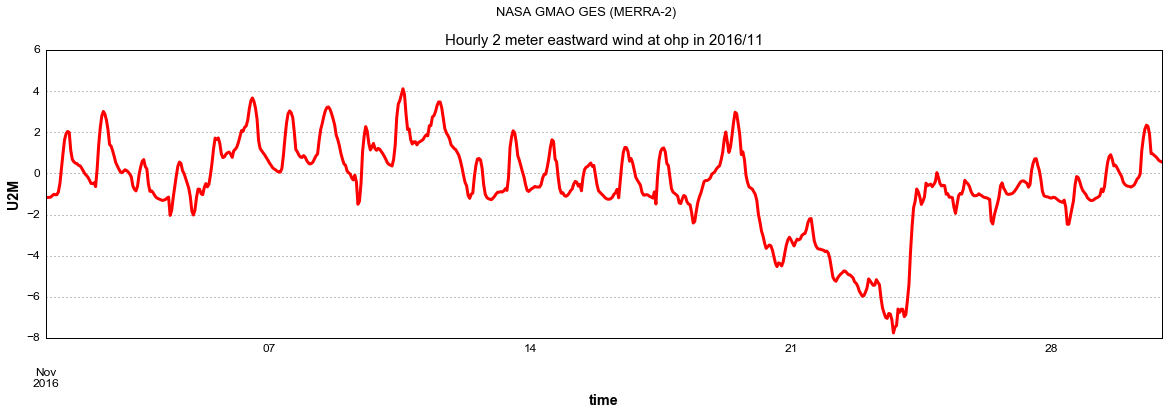

In [45]:
PlotTimeSeries(9,figfile_u2m)

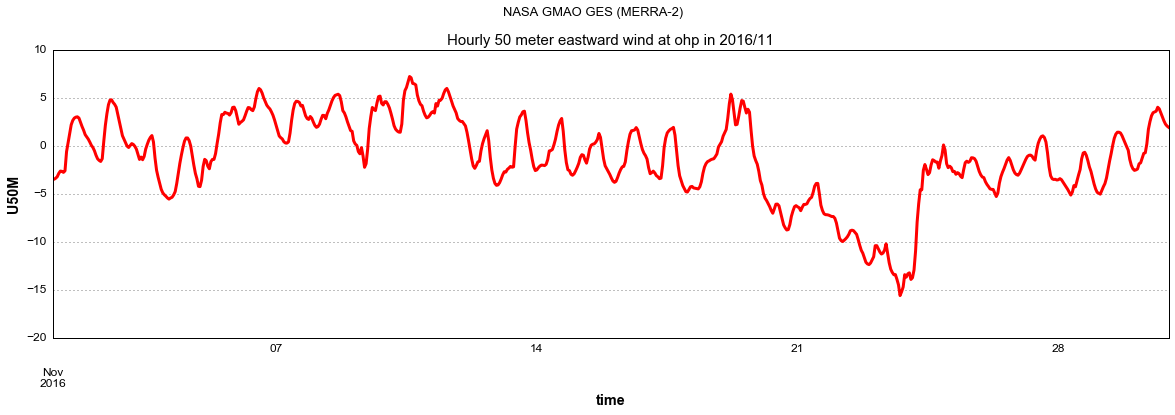

In [46]:
PlotTimeSeries(10,figfile_u50m)

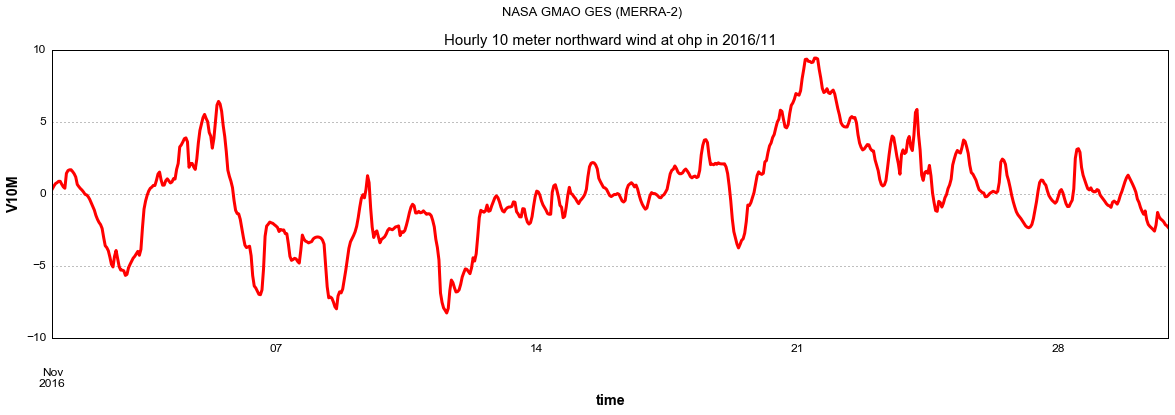

In [47]:
PlotTimeSeries(11,figfile_v10m)

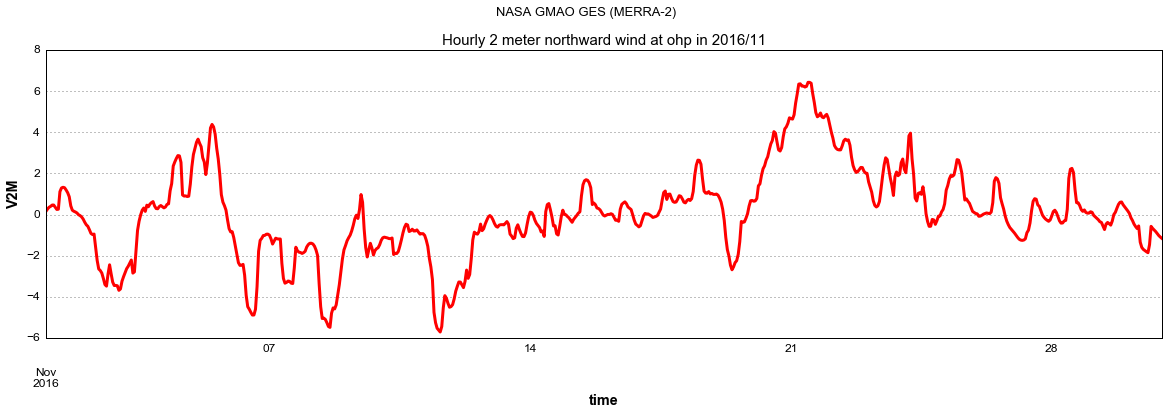

In [48]:
PlotTimeSeries(12,figfile_v2m)

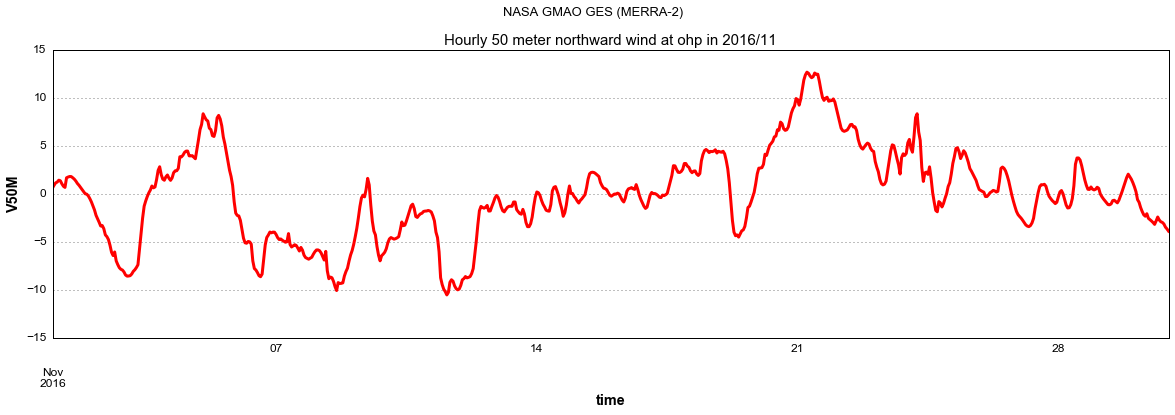

In [49]:
PlotTimeSeries(13,figfile_v50m)

## 5) Output

In [50]:
df_inst1_2d_asm_Nx.index.name='time'
df_inst1_2d_asm_Nx.describe()

,PS,T10M,T2M,TO3,TOX,TQI,TQL,TS,U10M,U2M,U50M,V10M,V2M,V50M
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,93774.710938,280.561890,279.869324,290.660889,0.006237,0.024694,0.076577,279.056976,-0.873471,-0.522847,-1.231734,-0.020325,0.021955,-0.088090
std,632.780669,3.988254,4.453650,22.728863,0.000487,0.050989,0.095721,5.421782,3.182245,2.116561,4.338954,3.250351,2.160979,4.634925
min,92384.640625,270.773041,269.714844,251.922699,0.005408,0.000000,0.000000,268.463745,-11.487646,-7.753606,-15.580361,-8.264384,-5.709053,-10.511650
25%,93347.462891,278.168152,276.653923,274.927795,0.005900,0.000011,0.003048,274.719315,-2.262013,-1.166809,-3.400830,-1.955248,-1.065619,-2.806863
50%,93721.386719,280.346954,279.787888,287.496506,0.006166,0.000931,0.032837,279.007690,-0.822777,-0.472520,-1.214488,-0.075527,-0.029689,-0.108816
75%,94129.212891,283.772430,283.689270,306.159142,0.006568,0.018782,0.117317,283.492989,1.405577,0.783036,2.122082,1.640904,0.975344,2.463160
max,95422.078125,289.985931,290.595459,349.622040,0.007495,0.379395,0.394043,293.283752,5.909451,4.116533,7.237700,9.439109,6.428907,12.690127


## 5)  Save dataset  in file pandas (csv)
----------------------------------------

In [51]:
dataset=df_inst1_2d_asm_Nx

In [52]:
dataset.index.name='time'

In [53]:
dataset.describe()

,PS,T10M,T2M,TO3,TOX,TQI,TQL,TS,U10M,U2M,U50M,V10M,V2M,V50M
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,93774.710938,280.561890,279.869324,290.660889,0.006237,0.024694,0.076577,279.056976,-0.873471,-0.522847,-1.231734,-0.020325,0.021955,-0.088090
std,632.780669,3.988254,4.453650,22.728863,0.000487,0.050989,0.095721,5.421782,3.182245,2.116561,4.338954,3.250351,2.160979,4.634925
min,92384.640625,270.773041,269.714844,251.922699,0.005408,0.000000,0.000000,268.463745,-11.487646,-7.753606,-15.580361,-8.264384,-5.709053,-10.511650
25%,93347.462891,278.168152,276.653923,274.927795,0.005900,0.000011,0.003048,274.719315,-2.262013,-1.166809,-3.400830,-1.955248,-1.065619,-2.806863
50%,93721.386719,280.346954,279.787888,287.496506,0.006166,0.000931,0.032837,279.007690,-0.822777,-0.472520,-1.214488,-0.075527,-0.029689,-0.108816
75%,94129.212891,283.772430,283.689270,306.159142,0.006568,0.018782,0.117317,283.492989,1.405577,0.783036,2.122082,1.640904,0.975344,2.463160
max,95422.078125,289.985931,290.595459,349.622040,0.007495,0.379395,0.394043,293.283752,5.909451,4.116533,7.237700,9.439109,6.428907,12.690127


In [54]:
dataset.head()

,PS,T10M,T2M,TO3,TOX,TQI,TQL,TS,U10M,U2M,U50M,V10M,V2M,V50M
time,,,,,,,,,,,,,,
2016-11-01 00:00:00,94772.718750,283.084259,280.614594,257.235260,0.005515,0.0,0.000750,277.447571,-2.281984,-1.150726,-3.456753,0.367677,0.156766,0.641324
2016-11-01 01:00:00,94749.953125,283.197571,280.567535,257.349976,0.005517,0.0,0.000935,277.110474,-2.303034,-1.171256,-3.465101,0.564804,0.265860,0.921481
2016-11-01 02:00:00,94726.351562,283.252808,280.531982,257.737762,0.005525,0.0,0.001091,276.829224,-2.256219,-1.164697,-3.357675,0.726053,0.355293,1.163338
2016-11-01 03:00:00,94696.187500,283.254791,280.496643,258.443604,0.005540,0.0,0.001901,276.555115,-2.181211,-1.153476,-3.201479,0.789319,0.398774,1.243740
2016-11-01 04:00:00,94690.429688,283.116943,280.520325,258.894226,0.005549,0.0,0.005436,276.496826,-1.993508,-1.084489,-2.852959,0.884109,0.464120,1.438297


In [55]:
dataset.to_csv(pandas_filename)

In [56]:
saved_dataset=pd.read_csv(pandas_filename)

In [57]:
saved_dataset.head()

,time,PS,T10M,T2M,TO3,TOX,TQI,TQL,TS,U10M,U2M,U50M,V10M,V2M,V50M
0,2016-11-01 00:00:00,94772.718750,283.084259,280.614594,257.235260,0.005515,0.0,0.000750,277.447571,-2.281984,-1.150726,-3.456753,0.367677,0.156766,0.641324
1,2016-11-01 01:00:00,94749.953125,283.197571,280.567535,257.349976,0.005517,0.0,0.000935,277.110474,-2.303034,-1.171256,-3.465101,0.564804,0.265860,0.921481
2,2016-11-01 02:00:00,94726.351562,283.252808,280.531982,257.737762,0.005525,0.0,0.001091,276.829224,-2.256219,-1.164697,-3.357675,0.726053,0.355293,1.163338
3,2016-11-01 03:00:00,94696.187500,283.254791,280.496643,258.443604,0.005540,0.0,0.001901,276.555115,-2.181211,-1.153476,-3.201479,0.789319,0.398774,1.243740
4,2016-11-01 04:00:00,94690.429688,283.116943,280.520325,258.894226,0.005549,0.0,0.005436,276.496826,-1.993508,-1.084489,-2.852959,0.884109,0.464120,1.438297


## 6) Convert dataset into a table and then save in a fits file
--------------------------------------------------------------------------

In [58]:
table = Table.from_pandas(saved_dataset)

In [59]:
table

time,PS,T10M,T2M,TO3,TOX,TQI,TQL,TS,U10M,U2M,U50M,V10M,V2M,V50M
str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2016-11-01 00:00:00,94772.71875,283.084259033,280.614593506,257.23526001,0.00551487784833,0.0,0.000749826431274,277.447570801,-2.28198385239,-1.1507256031,-3.45675253868,0.367677092552,0.156765818596,0.641324162483
2016-11-01 01:00:00,94749.953125,283.197570801,280.5675354,257.349975586,0.00551676377654,0.0,0.000935316085815,277.110473633,-2.30303430557,-1.17125606537,-3.46510052681,0.564804315567,0.265859603882,0.921481490135
2016-11-01 02:00:00,94726.3515625,283.252807617,280.531982422,257.737762451,0.00552519457415,0.0,0.00109052658081,276.829223633,-2.25621938705,-1.16469693184,-3.35767507553,0.726052641869,0.355293393135,1.16333758831
2016-11-01 03:00:00,94696.1875,283.25479126,280.496643066,258.443603516,0.00554028525949,0.0,0.00190114974976,276.555114746,-2.18121147156,-1.15347647667,-3.20147895813,0.789319038391,0.398774266243,1.243740201
2016-11-01 04:00:00,94690.4296875,283.116943359,280.520324707,258.894226074,0.0055494075641,0.0,0.00543594360352,276.496826172,-1.99350845814,-1.08448886871,-2.8529586792,0.884108662605,0.464120388031,1.43829703331
2016-11-01 05:00:00,94683.7734375,282.869506836,280.465087891,259.337280273,0.00555926561356,0.0,0.0116844177246,276.568572998,-1.8326086998,-1.01608514786,-2.61567759514,0.881303668022,0.463192760944,1.3822157383
2016-11-01 06:00:00,94676.484375,282.593383789,280.311523438,259.581451416,0.00556397344917,0.0,0.013801574707,276.616149902,-1.85637497902,-1.03715372086,-2.63629198074,0.673396766186,0.353725969791,1.05987644196
2016-11-01 07:00:00,94697.515625,282.403320312,280.30670166,258.877716064,0.00556542538106,0.0,0.0150489807129,277.819732666,-1.91089081764,-1.0314129591,-2.74854040146,0.494378626347,0.248861730099,0.805325031281
2016-11-01 08:00:00,94727.3125,283.611755371,283.488250732,258.987304688,0.00556673295796,0.0,0.0319671630859,283.796783447,-1.47083306313,-0.903034210205,-2.58852005005,0.399343490601,0.259727835655,0.686652302742


In [60]:
table.write(fits_filename,format='fits',overwrite=True)